In [1]:
from scipy.io import arff
import matplotlib.pyplot as plt
from sklearn import metrics
from hdbscan import HDBSCAN
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

In [9]:
# Chargement des datasets
def load_datasets():
    datasetA, metaA = arff.loadarff(open('R15.arff','r'))
    datasetB, metaB = arff.loadarff(open('disk-1000n.arff','r'))
    datasetC, metaC = arff.loadarff(open('spiralsquare.arff','r'))
    datasetD, metaD = arff.loadarff(open('elly-2d10c13s.arff','r'))
    datasetE, metaE = arff.loadarff(open('cure-t2-4k.arff','r'))
    datasetF, metaF = arff.loadarff(open('square5.arff','r'))
    datasetG, metaG = arff.loadarff(open('rings.arff','r'))
    datasetH, metaH = arff.loadarff(open('cluto-t8-8k.arff','r'))
    datasetI, metaI = arff.loadarff(open('complex8.arff','r'))
    datasetJ, metaJ = arff.loadarff(open('complex9.arff','r'))
    
    return ([datasetA, datasetB, datasetC, datasetD, datasetE, datasetF, datasetG, datasetH, datasetI, datasetJ],[metaA, metaB, metaC, metaD, metaE, metaF, metaG, metaH, metaI, metaJ])

In [10]:
data, metadata = load_datasets()

In [4]:
# Détermination des valeurs optimales de eps et minSamples en les faisant varier simultanéement
def hdbscan_params(dataset, nb_min, nb_max, min_eps,max_eps,step_eps):
    
    s_duration_sil = []
    s_duration_db = []
    s_duration_chi = []
    
    s_sil_score = []
    s_db_score = []
    s_chi_score = []
    
    s_labels_sil = []
    s_labels_db = []
    s_labels_chi = []

    samp_eps_sil = []
    samp_eps_db = []
    samp_eps_chi = []
    
    X = [[x,y] for (x,y,c) in dataset]
    
    all_samp = []

    for samp in range(nb_min,nb_max):
        duration = []
        sil_score = []
        db_score = []
        chi_score = []
        dlabels = []

        all_eps = []
        
        for e in np.arange(min_eps,max_eps,step_eps):
            start_time = time.time()
            hdbscan = HDBSCAN(cluster_selection_epsilon=float(e), min_samples=samp).fit(X)
            elapsed = time.time() - start_time
            labels = hdbscan.labels_
            if np.unique(labels).shape[0] < 2:
                continue
            dlabels.append(labels)
            sil = metrics.silhouette_score(X, labels)
            db = metrics.davies_bouldin_score(X, labels)
            chi = metrics.calinski_harabaz_score(X, labels)
            sil_score.append(sil)
            db_score.append(db)
            chi_score.append(chi)
            duration.append(elapsed)
            all_eps.append(e)

        if len(sil_score) < 1:
            continue
        best_eps_sil = sil_score.index(max(sil_score))
        best_eps_db = db_score.index(min(db_score))
        best_eps_chi = chi_score.index(max(chi_score))
        
        all_eps = np.arange(min_eps,max_eps,step_eps)
        
        samp_eps_sil.append(all_eps[best_eps_sil])
        samp_eps_db.append(all_eps[best_eps_db])
        samp_eps_chi.append(all_eps[best_eps_chi])
        
        s_sil_score.append(sil_score[best_eps_sil])
        s_db_score.append(db_score[best_eps_db])
        s_chi_score.append(chi_score[best_eps_chi])
        
        s_duration_sil.append(duration[best_eps_sil])
        s_duration_db.append(duration[best_eps_db])
        s_duration_chi.append(duration[best_eps_chi])

        s_labels_sil.append(dlabels[best_eps_sil])
        s_labels_db.append(dlabels[best_eps_db])
        s_labels_chi.append(dlabels[best_eps_chi])

        all_samp.append(samp)
        
    best_samp_sil_index = s_sil_score.index(max(s_sil_score))
    best_samp_db_index = s_db_score.index(min(s_db_score))
    best_samp_chi_index = s_chi_score.index(max(s_chi_score))
    
    best_samp_sil = all_samp[best_samp_sil_index]
    best_samp_db = all_samp[best_samp_db_index]
    best_samp_chi = all_samp[best_samp_chi_index]
    
    best_eps_sil = samp_eps_sil[best_samp_sil_index]
    best_eps_db = samp_eps_db[best_samp_db_index]
    best_eps_chi = samp_eps_chi[best_samp_chi_index]

    print("best with silhouette coefficient: eps=", samp_eps_sil[best_samp_sil_index],"min_samples=", best_samp_sil)
    print("best with DB index: eps=",samp_eps_db[best_samp_db_index],"min_samples=", best_samp_db)
    print("best with Calinski and Harabasz index: eps=",samp_eps_chi[best_samp_chi_index],"min_samples=", best_samp_chi)

    plt.plot(all_samp,s_sil_score,label = "silhouette coefficient")
    plt.plot(all_samp,s_db_score,label = "DB index")
    plt.xlabel('min samples')
    plt.ylabel('score')
    plt.legend()
    plt.show()

    plt.plot(all_samp,s_chi_score,label = "Calinski and Harabasz index")
    plt.xlabel('min samples')
    plt.ylabel('score')
    plt.legend()
    plt.show()

    plt.plot(all_samp,s_duration_sil,label = "Execution time - silhouette coefficient")
    plt.plot(all_samp,s_duration_db,label = "Execution time - DB index")
    plt.plot(all_samp,s_duration_chi,label = "Execution time - Calinski and Harabasz index")
    plt.xlabel('min samples')
    plt.ylabel('time')
    plt.legend()
    plt.show()
      
    return ((best_samp_sil,best_eps_sil,s_labels_sil[best_samp_sil_index]),
            (best_samp_db,best_eps_db,s_labels_db[best_samp_db_index]),
            (best_samp_chi,best_eps_chi,s_labels_chi[best_samp_chi_index]))

Dataset: R15
	x's type is numeric
	y's type is numeric
	class's type is nominal, range is ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15')

best with silhouette coefficient: eps= 0.1 min_samples= 2
best with DB index: eps= 0.7000000000000001 min_samples= 2
best with Calinski and Harabasz index: eps= 0.1 min_samples= 2


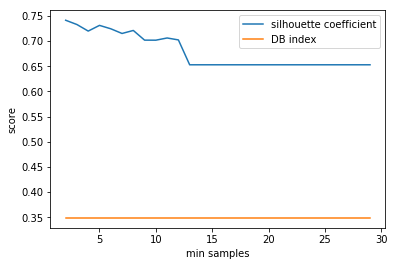

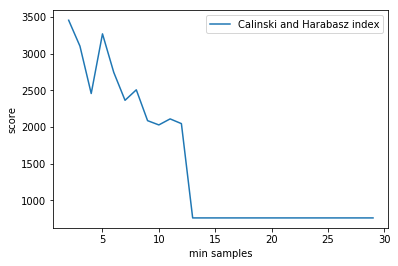

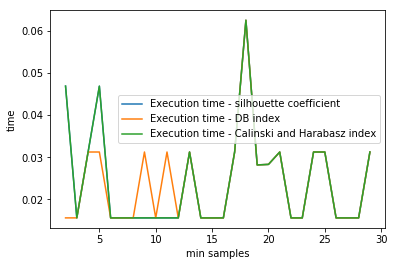

k with silhouette coefficient: 16
k with DB index: 8
k with Calinski and Harabasz index: 16


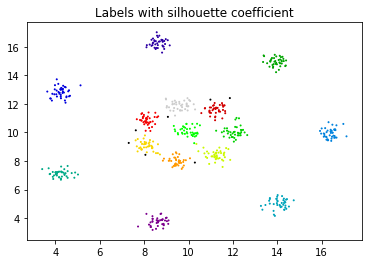

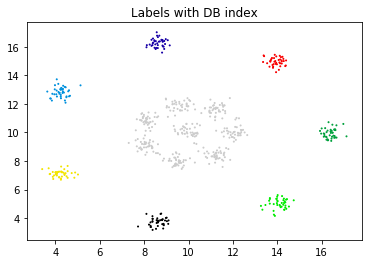

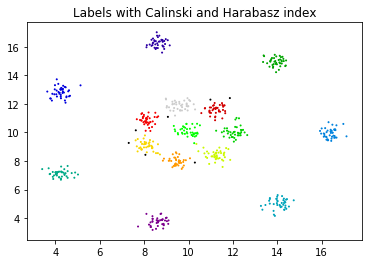

Dataset: disk-1000n
	x's type is numeric
	y's type is numeric
	class's type is nominal, range is ('0', '1')

best with silhouette coefficient: eps= 1.5 min_samples= 21
best with DB index: eps= 1.0 min_samples= 11
best with Calinski and Harabasz index: eps= 1.5 min_samples= 21


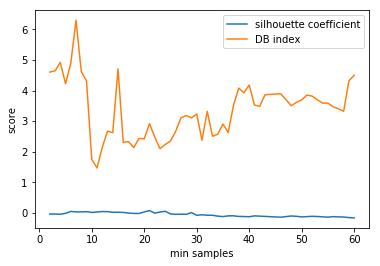

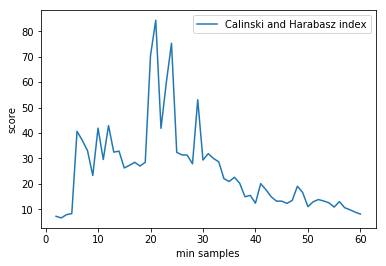

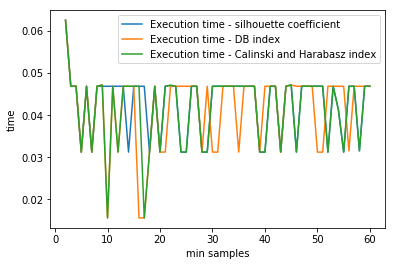

k with silhouette coefficient: 3
k with DB index: 17
k with Calinski and Harabasz index: 3


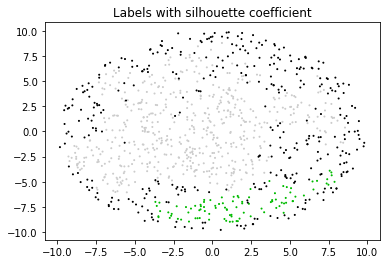

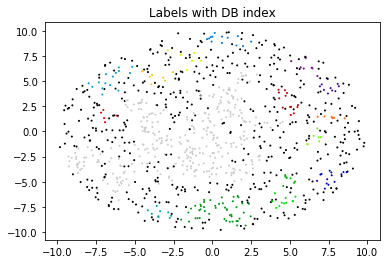

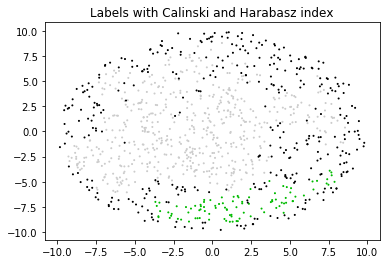

Dataset: spiralsquare
	a0's type is numeric
	a1's type is numeric
	CLASS's type is nominal, range is ('0', '1', '2', '3', '4', '5')

best with silhouette coefficient: eps= 0.1 min_samples= 51
best with DB index: eps= 0.1 min_samples= 99
best with Calinski and Harabasz index: eps= 0.1 min_samples= 54


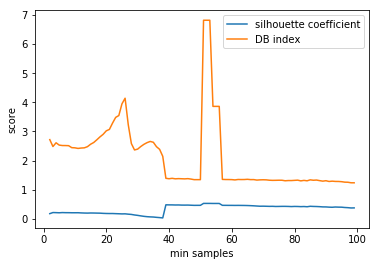

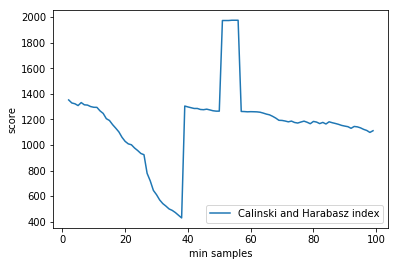

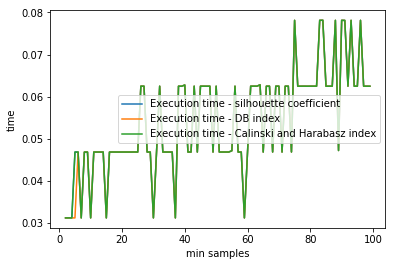

k with silhouette coefficient: 3
k with DB index: 6
k with Calinski and Harabasz index: 3


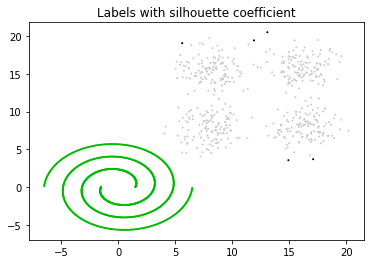

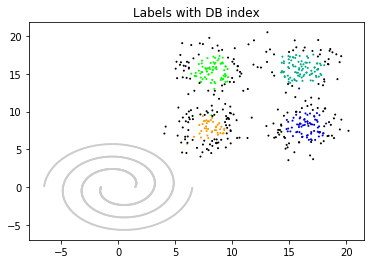

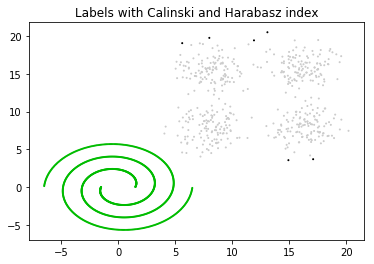

Dataset: elly-2d5c13s
	x's type is numeric
	y's type is numeric
	class's type is nominal, range is ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

best with silhouette coefficient: eps= 0.1 min_samples= 58
best with DB index: eps= 0.1 min_samples= 16
best with Calinski and Harabasz index: eps= 0.1 min_samples= 30


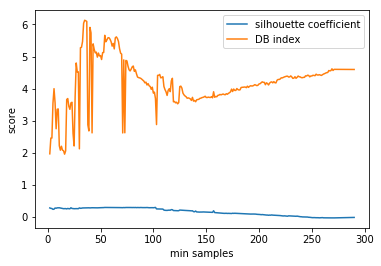

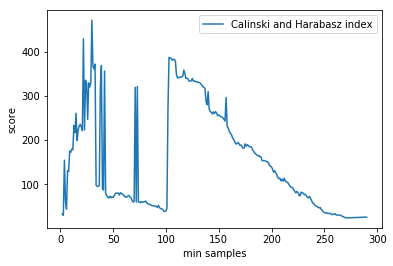

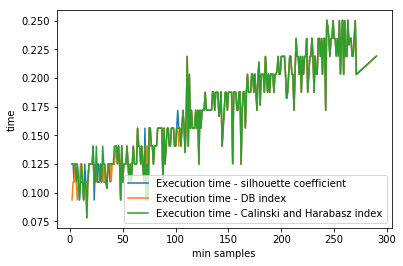

k with silhouette coefficient: 3
k with DB index: 9
k with Calinski and Harabasz index: 3


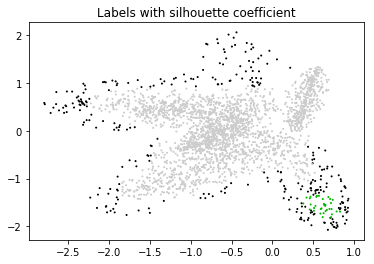

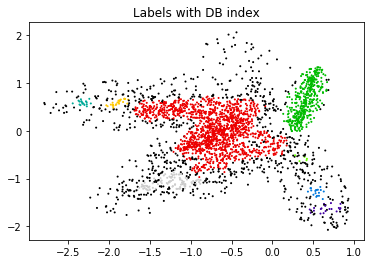

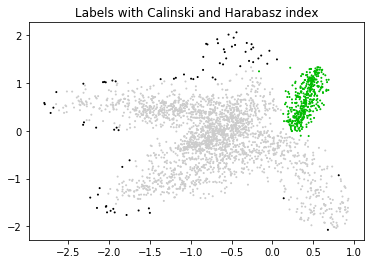

Dataset: cure-t2-4k
	x's type is numeric
	y's type is numeric
	class's type is nominal, range is ('0', '1', '2', '3', '4', '5', 'noise')

best with silhouette coefficient: eps= 0.15000000000000002 min_samples= 72
best with DB index: eps= 0.15000000000000002 min_samples= 4
best with Calinski and Harabasz index: eps= 0.2 min_samples= 72


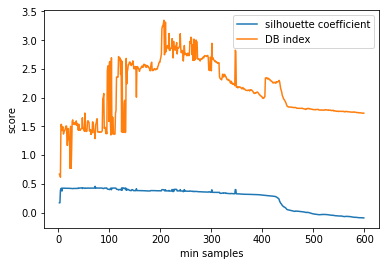

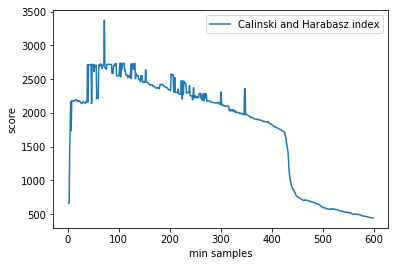

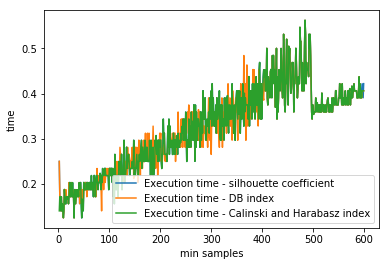

k with silhouette coefficient: 6
k with DB index: 3
k with Calinski and Harabasz index: 5


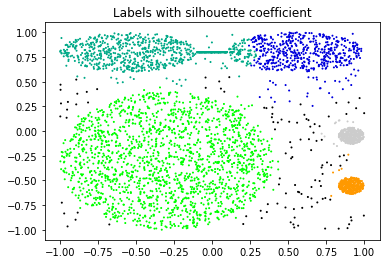

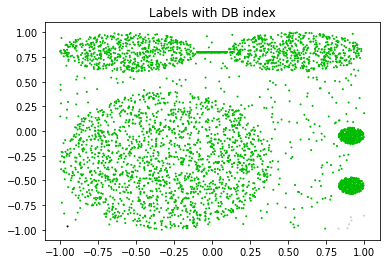

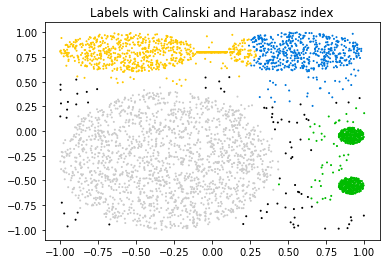

Dataset: square5
	a0's type is numeric
	a1's type is numeric
	class's type is nominal, range is ('0', '1', '2', '3')

best with silhouette coefficient: eps= 1.5 min_samples= 21
best with DB index: eps= 0.5 min_samples= 16
best with Calinski and Harabasz index: eps= 1.0 min_samples= 18


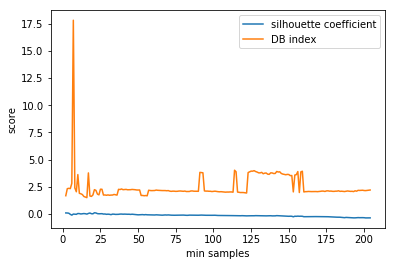

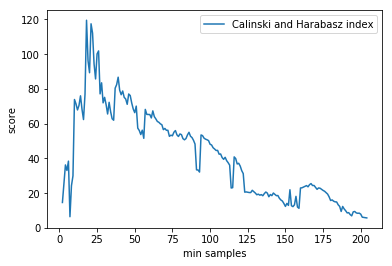

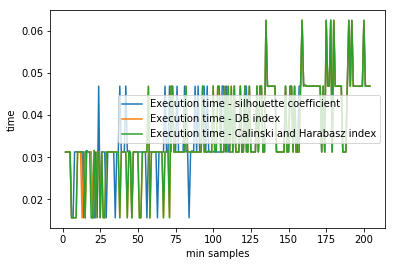

k with silhouette coefficient: 3
k with DB index: 7
k with Calinski and Harabasz index: 4


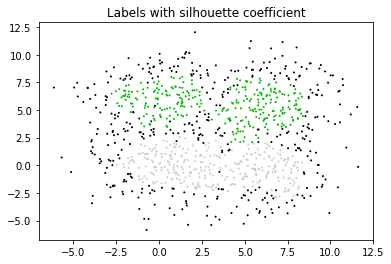

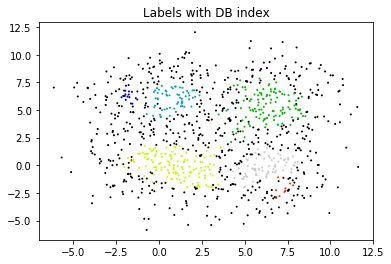

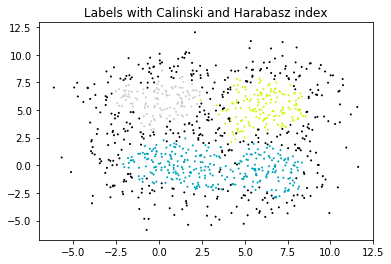

Dataset: Rings
	x's type is numeric
	y's type is numeric
	class's type is nominal, range is ('0', '1', '2')

best with silhouette coefficient: eps= 2.0 min_samples= 6
best with DB index: eps= 1.0 min_samples= 7
best with Calinski and Harabasz index: eps= 1.0 min_samples= 2


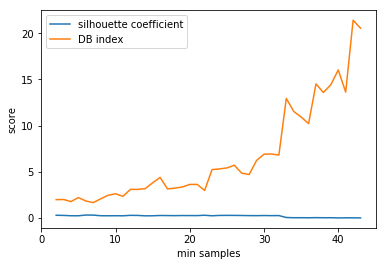

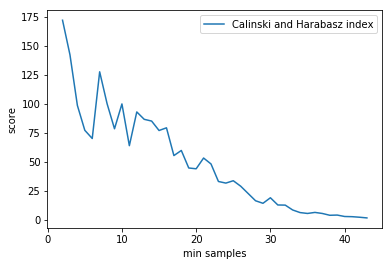

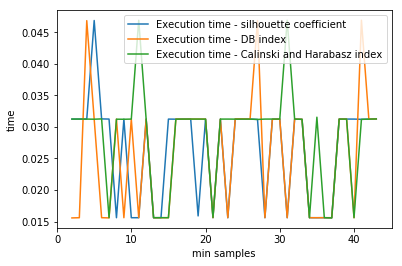

k with silhouette coefficient: 3
k with DB index: 15
k with Calinski and Harabasz index: 10


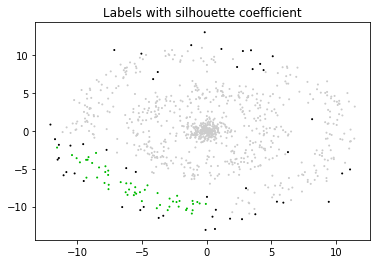

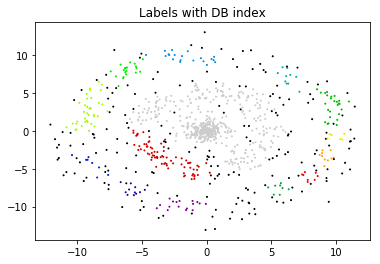

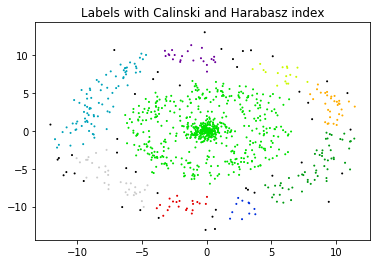

Dataset: cluto-t8-8k
	x's type is numeric
	y's type is numeric
	CLASS's type is nominal, range is ('0', '1', '2', '3', '4', '5', '6', '7', 'noise')



KeyboardInterrupt: 

In [5]:
# Parametres a tester pour chaque dataset (min_eps,max_eps,step_eps,min_nb_samples,max_nb_samples)
params = [(0.1,3.0,0.1,2,30),
          (1.0,20.0,0.5,2,600),
          (0.1,1.0,0.1,2,100),
          (0.1,2.0,0.05,2,600),
          (0.05,1.5,0.05,2,600),
          (0.5,15.0,0.5,2,500),
          (0.5,20.0,0.5,2,600),
          (1,200,10,2,50),
          (1,200,10,2,500),
          (1,200,10,2,500)]

for i in range(len(data)):
    dataset = data[i]
    meta = metadata[i]
    (min_eps,max_eps,step_eps,min_nb_samples,max_nb_samples) = params[i]
    print(meta)
    
    ((minpts_sil,eps_sil,best_labels_sil),
     (minpts_db,eps_db,best_labels_db),
     (minpts_chi,eps_chi,best_labels_chi)) = hdbscan_params(data[i],min_nb_samples,max_nb_samples,min_eps,max_eps,step_eps)

    print("k with silhouette coefficient:",np.unique(best_labels_sil).shape[0])
    print("k with DB index:",np.unique(best_labels_db).shape[0])
    print("k with Calinski and Harabasz index:",np.unique(best_labels_chi).shape[0])

    plt.scatter(dataset[meta.names()[0]],
                        dataset[meta.names()[1]],
                        c = best_labels_sil,
                        s = 1, cmap = 'nipy_spectral')
    plt.title("Labels with silhouette coefficient")
    plt.show()

    plt.scatter(dataset[meta.names()[0]],
                        dataset[meta.names()[1]],
                        c = best_labels_db,
                        s = 1, cmap = 'nipy_spectral')
    plt.title("Labels with DB index")
    plt.show()

    plt.scatter(dataset[meta.names()[0]],
                        dataset[meta.names()[1]],
                        c = best_labels_chi,
                        s = 1, cmap = 'nipy_spectral')
    plt.title("Labels with Calinski and Harabasz index")
    plt.show()